In [1]:
import numpy as np
from scipy import optimize
import networkx as nx
import matplotlib.pyplot as plt
import pickle
import time
from dwave_qbsolv import QBSolv
import dimod
from dimod.reference import samplers
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite, FixedEmbeddingComposite
from minorminer import find_embedding

init_notebook_mode(connected=True)

# Run the experiments

In [2]:
#Useful functions

def pseudo_likelihood(beta_eff,samples):
    J = - 1.0
    L = 0.0
    N = samples.shape[1]
    D = samples.shape[0]
    for i in range(D-1):
        for j in range(N-1):
            if j is 0:
                L += -np.log(1+np.exp(-2*(J*samples[i,j]*samples[i,j+1])*beta_eff))
            elif j is N-1:
                L += -np.log(1+np.exp(-2*(J*samples[i,j]*samples[i,j-1])*beta_eff))    
            else:
                L += -np.log(1+np.exp(-2*(J*samples[i,j]*samples[i,j+1]+J*samples[i,j]*samples[i,j-1])*beta_eff))
    return -L/(N*D)

In [6]:
#Global variables and problem setting
chain_lenght = 300
num_samples = 100

h = dict(enumerate([0.0 for i in range(chain_lenght-1)]))
J = {(i, i+1): 1.0 for i in range(chain_lenght-1)}

bqm = dimod.BinaryQuadraticModel.from_ising(h, J)
qpu_sampler = DWaveSampler(solver='DW_2000Q_2_1') #DW_2000Q_2_1 or DW_2000Q_5(lower noise)
embedding = find_embedding(J,qpu_sampler.edgelist)
sampler = FixedEmbeddingComposite(qpu_sampler, embedding)

H = -(-np.diag(np.ones(chain_lenght-1), -1) -np.diag(np.ones(chain_lenght-1), 1))/chain_lenght

print('Found a valid embedding for the specified problem.')

Found a valid embedding for the specified problem.


In [4]:
#Thermalization at different times for a fixed anneal_param
anneal_param = 0.9 #the lowest value allowed and the closest thing to "no driving" we can achieve

mean_E_therm = []
var_E_therm = []

tic = time.time()
for anneal_lenght in np.linspace(1,200,num = 10):
    E_fin = []
    for i in range(num_samples):
        init_state = np.random.choice([-1,1],size=(chain_lenght,),p=[1/2,1/2])
        #init_state = np.ones(chain_lenght)
        E_init = np.dot(init_state,np.dot(H,init_state))

        initial_state= dict(enumerate(init_state.tolist()))

        samples = sampler.sample(bqm, initial_state=initial_state, anneal_schedule=[[0,1], [anneal_lenght*anneal_param,anneal_param], [anneal_lenght,1]], num_reads=10)
        for s in samples.samples():
            final_state = np.array(list(s.values()))
            E_fin.append(np.dot(final_state,np.dot(H,final_state)))
    mean_E_therm.append(np.mean(np.array(E_fin)))
    var_E_therm.append(np.var(np.array(E_fin)))
toc = time.time()

print('Thermalization at s =', anneal_param,'completed.\n')
print('Elapsed time:', toc-tic,'s.\n')

Thermalization at s = 0.9 completed.

Elapsed time: 2177.911694288254 s.



In [5]:
#Work statistics at different anneal_param
anneal_lenght = 100

mean_E = []
var_E = []
mean_Q = []
var_Q = []
beta_eff = []

tic = time.time()
#to save QPU time you can just do one value of anneal_param instead af sweeping the full range
for anneal_param in np.linspace(0.1,0.9,num = 9):
    configurations = []
    E_fin = []
    Q = []
    for i in range(num_samples):
        # Initial state at infinite temperature
        init_state = np.random.choice([-1,1],size=(chain_lenght,),p=[1/2,1/2])
        E_init = np.dot(init_state,np.dot(H,init_state))
        initial_state= dict(enumerate(init_state.tolist()))
        # Reverse annealing 
        samples = sampler.sample(bqm, initial_state=initial_state, anneal_schedule=[[0,1], [anneal_lenght/2,anneal_param], [anneal_lenght,1]], num_reads=10)
        for s in samples.samples():
            final_state = np.array(list(s.values()))
            configurations.append(final_state)
            E_fin.append(np.dot(final_state,np.dot(H,final_state)))
            Q.append(np.dot(final_state,np.dot(H,final_state))-E_init)
    optim = optimize.minimize(pseudo_likelihood, 1.0, args = (np.array(configurations),))
    beta_eff.append(optim.x)
    mean_E.append(np.mean(np.array(E_fin)))
    var_E.append(np.var(np.array(E_fin)))
    mean_Q.append(np.mean(np.array(Q)))
    var_Q.append(np.var(np.array(Q)))
toc = time.time() 

print('Collected proper work statistics.')
print('Elapsed time:', toc-tic,'s.\n')

Collected proper work statistics.
Elapsed time: 3262.338079214096 s.



In [6]:
#if you want to save the experimental data
with open('experimental_results.pkl', 'wb') as f:
    pickle.dump([mean_E_therm, var_E_therm, beta_eff, mean_E, var_E, mean_Q, var_Q], f)
    
print('Saved data into ->', f.name)

Saved data into -> experimental_results.pkl


# Plot results

In [2]:
#if you want to restore the previous experimental data
with open('experimental_results.pkl', 'rb') as f:
    [mean_E_therm, var_E_therm, beta_eff, mean_E, var_E, mean_Q, var_Q] = pickle.load(f)
    
print('Loaded data from <-', f.name)

Loaded data from <- experimental_results.pkl


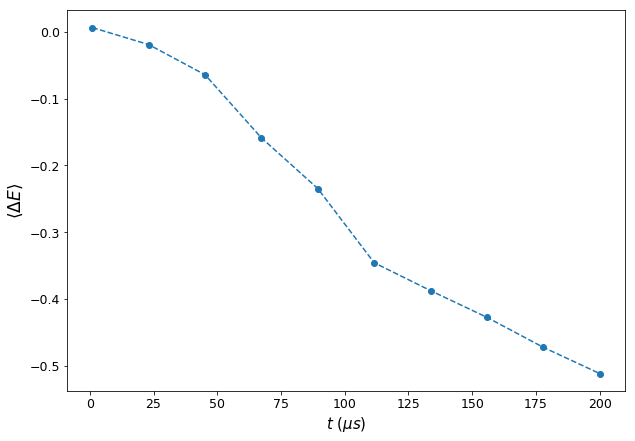

In [30]:
x = np.linspace(1,200,num = 10)
y = np.array(mean_E_therm)
plt.figure(num=None, figsize=(10, 7))
plt.plot(x,y,'o--')
plt.ylabel(r'$\langle \Delta E_1 \rangle $',fontsize=17)
plt.yticks(fontsize=12.5)
plt.xlabel(r'$t$ $(\mu s)$',fontsize=15)
plt.xticks(fontsize=12.5)
plt.show()

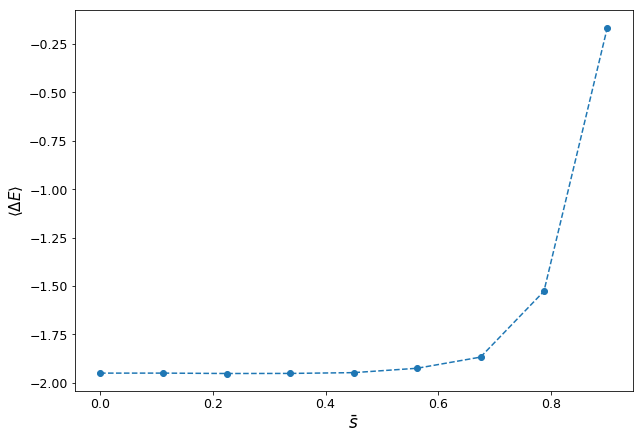

In [35]:
x = np.linspace(0,0.9,num = 9)
y = np.array(mean_E)
plt.figure(num=None, figsize=(10, 7))
plt.plot(x,y,'o--')
plt.yticks(fontsize=12.5)
plt.ylabel(r'$\langle \Delta E_1 \rangle$',fontsize=15)
plt.xlabel(r'$\bar{s}$',fontsize=17)
plt.xticks(fontsize=12.5)
plt.show()

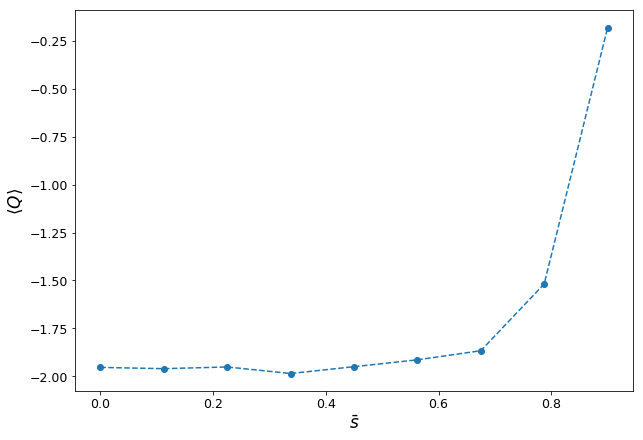

In [37]:
x = np.linspace(0,0.9,num = 9)
y = np.array(mean_Q)
plt.figure(num=None, figsize=(10, 7))
plt.plot(x,y,'o--')
plt.yticks(fontsize=12.5)
plt.ylabel(r'$\langle Q \rangle$',fontsize=17)
plt.xlabel(r'$\bar{s}$',fontsize=17)
plt.xticks(fontsize=12.5)
plt.show()

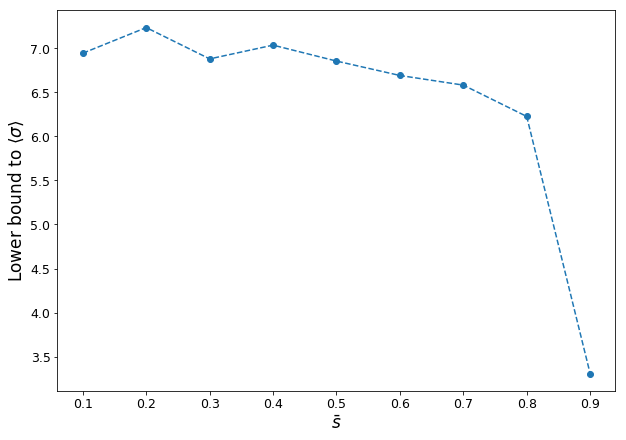

In [49]:
x = np.linspace(0.1,0.9,num = 9)
chain_lenght = 300
k=mean_Q/np.sqrt(var_Q+np.square(mean_Q))
y = 2*k*np.arctanh(k)
#z = (2*(np.array(mean_Q)**2)/(np.array(var_Q)))/chain_lenght
plt.figure(num=None, figsize=(10, 7))
plt.plot(x,y,'o--')
#plt.plot(x,z,'x--')
plt.yticks(fontsize=12.5)
plt.ylabel(r'Lower bound to $\langle \sigma \rangle$',fontsize=17)
plt.xlabel(r'$\bar{s}$',fontsize=17)
plt.xticks(fontsize=12.5)
plt.show()

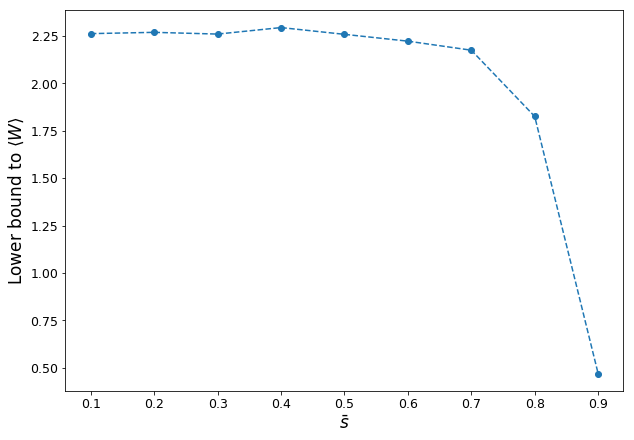

In [51]:
x = np.linspace(0.1,0.9,num = 9)
chain_lenght = 300
k=mean_Q/np.sqrt(var_Q+np.square(mean_Q))
y=2*k*np.arctanh(k)
z=(-np.array(mean_Q)-k/3.25)
plt.figure(num=None, figsize=(10, 7))
plt.plot(x,z,'o--')
plt.yticks(fontsize=12.5)
plt.ylabel(r'Lower bound to $\langle W \rangle$',fontsize=17)
plt.xlabel(r'$\bar{s}$',fontsize=17)
plt.xticks(fontsize=12.5)
plt.show()

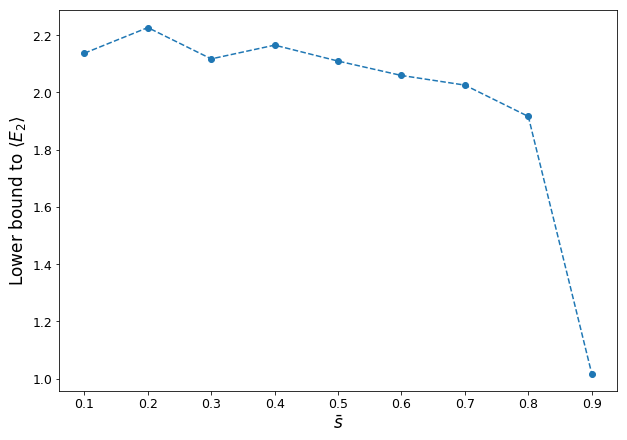

In [52]:
x = np.linspace(0.1,0.9,num = 9)
chain_lenght = 300
k=mean_Q/np.sqrt(var_Q+np.square(mean_Q))
y=2*k*np.arctanh(k)/3.25
plt.figure(num=None, figsize=(10, 7))
plt.plot(x,y,'o--')
plt.yticks(fontsize=12.5)
plt.ylabel(r'Lower bound to $\langle \Delta E_2 \rangle$',fontsize=17)
plt.xlabel(r'$\bar{s}$',fontsize=17)
plt.xticks(fontsize=12.5)
plt.show()